In [2]:
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import opendatasets as od
import pandas
from keras import layers, Model

In [9]:
od.download("https://www.kaggle.com/datasets/gonzajl/tumores-cerebrales-mri-dataset")

Skipping, found downloaded files in "./tumores-cerebrales-mri-dataset" (use force=True to force download)


In [3]:
datos = pandas.read_csv("./tumores-cerebrales-mri-dataset/datos.csv")

In [4]:
# Mezcla la información en el dataset
datos = datos.sample(frac=1).reset_index(drop=True)

In [5]:
def cargar_imagenes(nombres, et):
    imagenes = []
    etiquetas = []
    for i in range(len(nombres)):
        ruta = 'tumores-cerebrales-mri-dataset/' + nombres[i][2:]
        imagen = cv2.imread(ruta, cv2.IMREAD_COLOR)
        #imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
        #imagen = imagen.reshape(imagen.shape[0], imagen.shape[0], 1)
        imagenes.append(imagen)
        etiquetas.append(list(et.iloc[i]))
    return imagenes, etiquetas

In [6]:
paths = datos.iloc[:, 0]
tags = datos.iloc[:, 1:]

In [7]:
imagenes, etiquetas = cargar_imagenes(paths, tags)

In [8]:
imagenes_entrenamiento, imagenes_prueba = imagenes[:8800], imagenes[8800:11000]
etiquetas_entrenamiento, etiquetas_prueba = etiquetas[:8800], etiquetas[8800:11000]

In [9]:
def mostrar_grafico_clases(etiquetas):
    cant_glioma = etiquetas.count([1, 0, 0, 0])
    cant_meningioma = etiquetas.count([0, 1, 0, 0])
    cant_pituitary = etiquetas.count([0, 0, 1, 0])
    cant_no_tumor = etiquetas.count([0, 0, 0, 1])

    categorias = ['glioma', 'meningioma', 'pituitary', 'no_tumor']
    cantidades = [cant_glioma, cant_meningioma, cant_pituitary, cant_no_tumor]

    plt.figure(figsize=(6, 4))
    barras = plt.bar(categorias, cantidades)

    for bar, cantidad in zip(barras, cantidades):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() / 2, str(cantidad), fontsize=12)

    plt.xlabel('Clases')
    plt.ylabel('Cantidad de Imágenes')
    plt.title('Cantidad de Imágenes por Clase')

    plt.show()

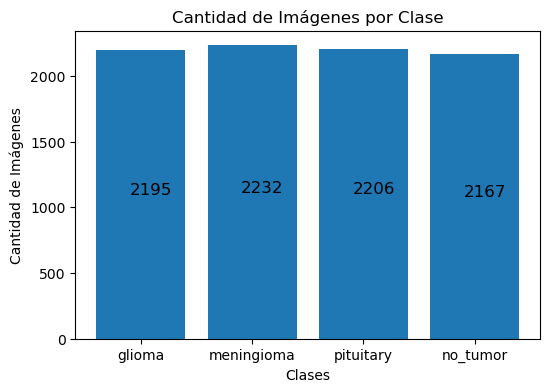

In [10]:
mostrar_grafico_clases(etiquetas_entrenamiento)

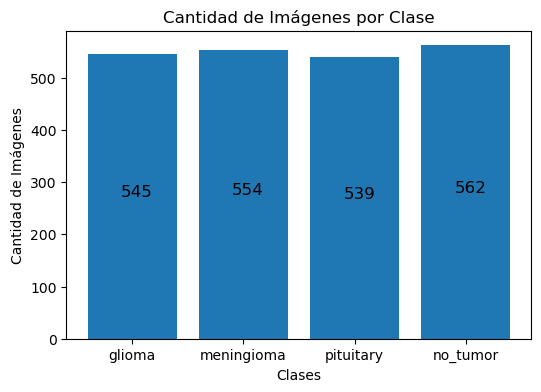

In [11]:
mostrar_grafico_clases(etiquetas_prueba)

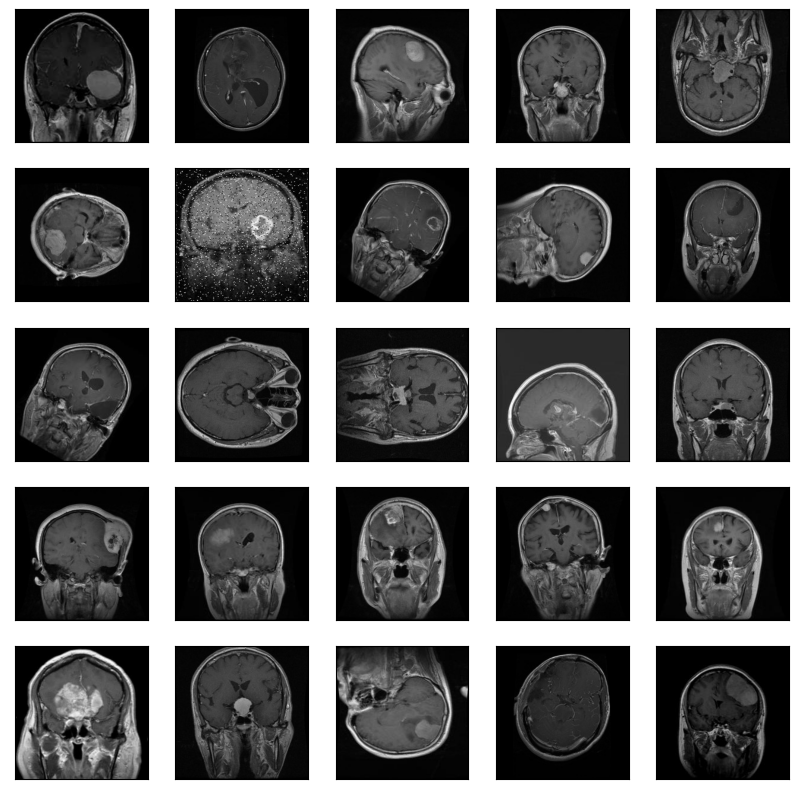

In [12]:
plt.figure(figsize = (10, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagenes_entrenamiento[i])

plt.show()

In [13]:
# Normalización de entradas y conversión de listas a tensores
imagenes_entrenamiento = np.array(imagenes_entrenamiento).astype(float) / 255
imagenes_prueba = np.array(imagenes_prueba).astype(float) / 255

etiquetas_entrenamiento = np.array(etiquetas_entrenamiento)
etiquetas_prueba = np.array(etiquetas_prueba)

In [17]:
base_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

base_model.trainable = False

num_classes = 4
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(num_classes, activation='sigmoid')(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=output)

94668760/94668760 [==============================] - 2s 0us/step


In [18]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
historial = model.fit(imagenes_entrenamiento, etiquetas_entrenamiento, epochs=20, validation_data=(imagenes_prueba, etiquetas_prueba))

Epoch 1/20


2023-10-01 16:01:14.333444: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5298585600 exceeds 10% of free system memory.


275/275 [==============================] - 216s 786ms/step - loss: 0.1740 - accuracy: 0.8703 - val_loss: 0.1520 - val_accuracy: 0.8786
Epoch 2/20
275/275 [==============================] - 213s 776ms/step - loss: 0.1452 - accuracy: 0.8926 - val_loss: 0.1461 - val_accuracy: 0.8836
Epoch 3/20
275/275 [==============================] - 213s 776ms/step - loss: 0.1232 - accuracy: 0.9049 - val_loss: 0.1349 - val_accuracy: 0.8973
Epoch 4/20
275/275 [==============================] - 212s 773ms/step - loss: 0.1072 - accuracy: 0.9207 - val_loss: 0.1256 - val_accuracy: 0.9009
Epoch 5/20
275/275 [==============================] - 214s 778ms/step - loss: 0.0958 - accuracy: 0.9318 - val_loss: 0.1246 - val_accuracy: 0.9073
Epoch 6/20
275/275 [==============================] - 213s 777ms/step - loss: 0.0822 - accuracy: 0.9400 - val_loss: 0.1071 - val_accuracy: 0.9223
Epoch 7/20
275/275 [==============================] - 213s 775ms/step - loss: 0.0727 - accuracy: 0.9503 - val_loss: 0.1075 - val_accura

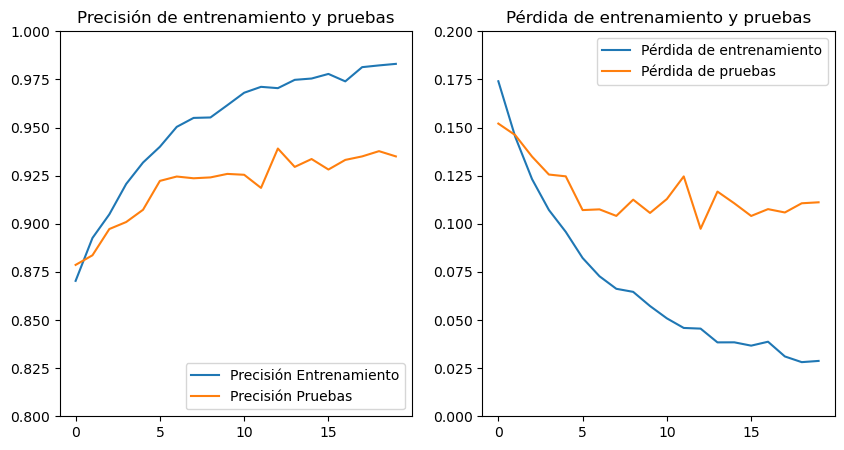

In [28]:
# Graficas de precisión y pérdida del modelo
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(20)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.ylim(0.8, 1)
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label= 'Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.ylim(0, 0.2)
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

In [29]:
def es_correcta(prediccion, esperado):
    return prediccion.index(max(prediccion)) == esperado.index(max(esperado))

In [30]:
correctas_segun_tipo = [0, 0, 0, 0]
falladas_segun_tipo = [0, 0, 0, 0]

predicciones = model.predict(imagenes_prueba)
print(f"Cantidad de predicciones: {len(predicciones)}")

for i in range(len(predicciones)):
    prediccion = list(predicciones[i])
    index = prediccion.index(max(prediccion))
    
    if es_correcta(prediccion, list(etiquetas_prueba[i])):
        correctas_segun_tipo[index] += 1  
    else: 
        falladas_segun_tipo[index] += 1
        
cant_totales = list(map(lambda x, y: x + y, correctas_segun_tipo, falladas_segun_tipo))
print("Etiquetas:   [G,  M,  P,  N]")
print(f"Total:       {cant_totales}")
print(f"Correctas:   {correctas_segun_tipo}")
print(f"Incorrectas: {falladas_segun_tipo}")

69/69 [==============================] - 45s 654ms/step
Cantidad de predicciones: 2200
Etiquetas:   [G,  M,  P,  N]
Total:       [507, 602, 539, 552]
Correctas:   [482, 516, 516, 543]
Incorrectas: [25, 86, 23, 9]
